# DAN model (network-wise)

## Concept

Use source and target data. *num_links* of both datasets are the same. However, in the source dataset, there are 25 days, while in the target dataset, there are int(29*20%) = 5 days. For validation, the data used is the rest 80% days of the target dataset, which is 20 days.

In [281]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.stats
from sklearn.manifold import TSNE
import seaborn as sns
import ipdb
import os

import dan_models
import dan_utils

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import TensorDataset

# Utils

In [282]:
def plot_loss(val, train, title):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.plot(val)
    ax1.set_xlabel('Batches')
    ax1.set_ylabel('MSELoss')
    ax1.set_ylim([0, max(val)])
    ax1.set_title('Validation loss')
    ax1.grid()
    ax2 = fig.add_subplot(122)
    ax2.plot(train)
    ax2.set_xlabel('Batches')
    ax2.set_ylabel('MSELoss')
    ax2.set_ylim([0, max(train)])
    ax2.set_title('Train loss')
    ax2.grid()
    plt.suptitle(title)

# Load data

In [283]:
class_set = [2, 3, 4]
randseed = 25
res = 11
v, v_class, id_402, part1, part2, seg, det_list_class, near_road_set  \
        = dan_utils.load_data(class_set, res, randseed)

There are 5 class(es)


C:\Users\10169\anaconda3\envs\dan_traff\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


# Data assembling

In [284]:
# ind, class
# 0  , blue
# 1  , green
# 2  , yellow  <--
# 3  , black   <--
# 4  , red     <--
class_src = 2
v_class1 = v_class[class_src]  # source
near_road1 = np.array(near_road_set[class_src])

class_tar = 3
v_class2 = v_class[class_tar]  # target
near_road2 = np.array(near_road_set[class_tar])

num_links = v_class1.shape[0]

In [285]:
near_road_src = near_road1
flow_src = v_class1.iloc[:, 2:-1]
prop = 1  # proportion of training data
from_day = 1
to_day = 24

image_train_source, image_test_source, day_train_source, day_test_source, label_train_source, label_test_source\
= dan_utils.sliding_window(
    flow_src, near_road_src, from_day, to_day, prop, num_links
)

(2772, 5, 12, 40)
(2772, 5, 12, 40)
(0, 5, 12, 40)
(2772, 40, 6)
(0, 40, 6)


In [286]:
near_road_tar = near_road2
flow_tar = v_class2.iloc[:, 2:-1]
prop = 3/10
from_day = 22
to_day = 31

image_train_target, image_test_target, day_train_target, day_test_target, label_train_target, label_test_target\
= dan_utils.sliding_window(
    flow_tar, near_road_tar, from_day, to_day, prop, num_links
)

dup_mul = image_train_source.shape[0]//image_train_target.shape[0]
dup_r   = image_train_source.shape[0]%image_train_target.shape[0]

image_train_target, day_train_target, label_train_target = \
np.concatenate((np.tile(image_train_target, [dup_mul, 1, 1, 1]), image_train_target[:dup_r, :, :, :]), axis=0),\
np.concatenate((np.tile(day_train_target, [dup_mul, 1, 1]), day_train_target[:dup_r, :, :]), axis=0),\
np.concatenate((np.tile(label_train_target, [dup_mul, 1, 1]), label_train_target[:dup_r, :, :]), axis=0)

(1008, 5, 12, 40)
(302, 5, 12, 40)
(706, 5, 12, 40)
(302, 40, 6)
(706, 40, 6)


In [287]:
t_input = image_train_source.shape[2]
t_pre = label_train_source.shape[2]
k = image_train_source.shape[1]

# Convolutional Network (DAN)

In [288]:
class traffic_convnet(nn.Module):
    
    def __init__(self, k, t_input, num_links, t_pre):
        super(traffic_convnet, self).__init__()
        
#         _, k, t_input, num_links = input_data.shape  # [BatchSize, k, t_input, num_links]
#         _, _, t_pre = input_HA.shape  # [BatchSize, num_links, t_pre]
        self.k, self.t_input, self.num_links, self.t_pre = k, t_input, num_links, t_pre

        
        # define backbone:
        self.bn1 = nn.BatchNorm2d(num_links)
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=num_links,
                out_channels=num_links,
                kernel_size=3,
                stride=1,
                padding_mode='zeros',
                padding=1
            ),  # ! no padding
            nn.ReLU()
        )
        self.avgpool1 = nn.AvgPool2d(
            kernel_size=2,
            stride=1
        )
        
        self.bn2 = nn.BatchNorm2d(num_links)
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=num_links,
                out_channels=num_links,
                kernel_size=3,
                stride=1,
                padding_mode='zeros',
                padding=1
            ),  # ! no padding
            nn.ReLU()
        )
        self.avgpool2 = nn.AvgPool2d(
            kernel_size=2,
            stride=1
        )
        
        self.bn3 = nn.BatchNorm2d(num_links)
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Sequential(
            nn.Linear(k*t_input*num_links, num_links*2*t_pre),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(num_links*2*t_pre, num_links*t_pre),
            nn.ReLU()
        )
        
        # para: [t_pre, num_links]
        self.para1 = nn.Parameter(torch.randn(t_pre, t_pre), requires_grad=False)
        self.para2 = nn.Parameter(torch.randn(t_pre, t_pre), requires_grad=False)
#         self.input_HA = input_HA  
                    
    def forward(self, x, input_HA):  # input_HA: [batch, num_links, t_pre]
        # x: [BatchSize, k, t_input, num_links]
        # -->[BatchSize, num_links, k, t_input]
        x = torch.transpose(torch.transpose(x, 1, 3), 2, 3)
        x = self.bn1(x)
#         ipdb.set_trace()
        x = self.conv1(x)
        pad1 = (1, 0, 1, 0)  ###
        x = F.pad(x, pad1)
        x = self.avgpool1(x)
        x = self.bn2(x)
        x = self.conv2(x)
        x = F.pad(x, pad1)
        x = self.avgpool2(x)
        x = self.bn3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(x)
        x = self.fc1(x)
#         x = self.fc2(x)
#         x = x.view(-1, self.num_links, self.t_pre)
#         x = torch.matmul(x, self.para1) + torch.matmul(input_HA, self.para2)
        return x

In [289]:
class traffic_dannet(nn.Module):
    
    def __init__(self, k, t_input, num_links, t_pre, if_mmd=False):
        super(traffic_dannet, self).__init__()
        self.sharedNet = traffic_convnet(k, t_input, num_links, t_pre)
        
#         _, k, t_input, num_links = input_data.shape  # [BatchSize, k, t_input, num_links]
#         _, _, t_pre = input_HA.shape  # [BatchSize, num_links, t_pre]
        self.k, self.t_input, self.num_links, self.t_pre = k, t_input, num_links, t_pre
        
        self.if_mmd = if_mmd
        
    def forward(self, source, input_HA, target):
        global device
        mmd_loss = torch.Tensor([0.0]).float().to(device)
        x = self.sharedNet(source, input_HA)
        
        if self.if_mmd == True:
            x_tar = self.sharedNet(target, input_HA)
            mmd_loss += mmd_rbf_accelerate(x, x_tar)
            
            x = self.sharedNet.fc2(x)
            x_tar = self.sharedNet.fc2(x_tar)
            mmd_loss += mmd_rbf_accelerate(x, x_tar)
            
            x = x.view(
                -1, self.num_links, self.t_pre
            )
            x_tar = x_tar.view(
                -1, self.num_links, self.t_pre
            )
            
            x = torch.matmul(x, self.sharedNet.para1) + torch.matmul(input_HA, self.sharedNet.para2)
            x_tar = torch.matmul(x_tar, self.sharedNet.para1) + torch.matmul(input_HA, self.sharedNet.para2)

            return x, x_tar, mmd_loss
        
        else:
#             ipdb.set_trace()
            x = self.sharedNet.fc2(x)
            x = x.view(-1, self.num_links, self.t_pre)
            x = torch.matmul(x, self.sharedNet.para1) + torch.matmul(input_HA, self.sharedNet.para2)
            
            return x, x, torch.Tensor([0.0]).float().to(device)


In [290]:
def cal_L2_dist(total):
    try:
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)
    except:
        total_cpu = total.to('cpu')
        len_ = total_cpu.shape[0]
        L2_distance = torch.zeros([len_, len_], device=total_cpu.device.type)
        for i in range(total_cpu.shape[1]):
            total0 = total_cpu[:, i].unsqueeze(0).expand(int(total_cpu.size(0)), int(total_cpu.size(0)))
            total1 = total_cpu[:, i].unsqueeze(1).expand(int(total_cpu.size(0)), int(total_cpu.size(0)))
            L2_dist = (total0 - total1)**2
            L2_distance += L2_dist
            
    return L2_distance


def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    #source = source.cpu()
    #target = target.cpu()
#     ipdb.set_trace()
    n_samples = int(source.size()[0])+int(target.size()[0])  # number of samples
    total = torch.cat([source, target], dim=0)
    L2_distance = cal_L2_dist(total)
                       
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val).to(total.device.type)  #/len(kernel_val)


def mmd_rbf_accelerate(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    global device
#     ipdb.set_trace(context=5)
    batch_size = int(source.size()[0])
    kernels = guassian_kernel(source, target,
        kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    loss = torch.Tensor([0.0]).float().to(device)
    for i in range(batch_size):
        s1, s2 = i, (i+1) % batch_size
        t1, t2 = s1 + batch_size, s2 + batch_size
        loss += kernels[s1, s2] + kernels[t1, t2]
        loss -= kernels[s1, t2] + kernels[s2, t1]
    return loss / float(batch_size)

def mmd_rbf_noaccelerate(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    global device
    batch_size = int(source.size()[0])
    kernels = guassian_kernel(source, target,
                              kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    loss = torch.mean(XX + YY - XY -YX)
    return loss.to(device)

# Trainning on Source Dataset

In [291]:
device = torch.device('cuda' if torch.cuda.is_available()==True else 'cpu')

image_train_source = torch.tensor(image_train_source, dtype=torch.float32, requires_grad=True).to(device)
image_test_source = torch.tensor(image_test_source, dtype=torch.float32, requires_grad=True).to(device)
day_train_source = torch.tensor(day_train_source, dtype=torch.float32, requires_grad=True).to(device)
day_test_source = torch.tensor(day_test_source, dtype=torch.float32, requires_grad=True).to(device)
label_train_source = torch.tensor(label_train_source, dtype=torch.float32, requires_grad=True).to(device)
label_test_source = torch.tensor(label_test_source, dtype=torch.float32, requires_grad=True).to(device)

image_train_target = torch.tensor(image_train_target, dtype=torch.float32, requires_grad=True).to(device)
image_test_target = torch.tensor(image_test_target, dtype=torch.float32, requires_grad=True).to(device)
day_train_target = torch.tensor(day_train_target, dtype=torch.float32, requires_grad=True).to(device)
day_test_target = torch.tensor(day_test_target, dtype=torch.float32, requires_grad=True).to(device)
label_train_target = torch.tensor(label_train_target, dtype=torch.float32, requires_grad=True).to(device)
label_test_target = torch.tensor(label_test_target, dtype=torch.float32, requires_grad=True).to(device)

In [308]:
batch_size = 128
src_train_dataset = TensorDataset(image_train_source, day_train_source, label_train_source)
tar_train_dataset = TensorDataset(image_train_target, day_train_target, label_train_target)

src_train_loader = torch.utils.data.DataLoader(src_train_dataset, batch_size, shuffle=False)
tar_train_loader = torch.utils.data.DataLoader(tar_train_dataset, batch_size, shuffle=False)

In [309]:
traff_dannet = traffic_dannet(k, t_input, num_links, t_pre, if_mmd=False).to(device)
traff_dannet.train()

loss_func = nn.MSELoss()
val_loss_set = []
train_loss_set = []


In [310]:
optimizer = optim.Adam(traff_dannet.parameters())

Epoch 0 success, val loss:2042530.62500, train loss:2587650.25000


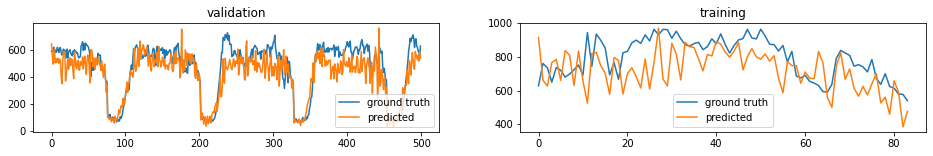

Epoch 5 success, val loss:2022799.62500, train loss:2556485.75000


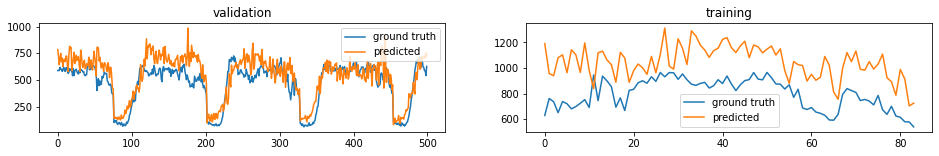

Epoch 10 success, val loss:2023337.00000, train loss:2555917.50000


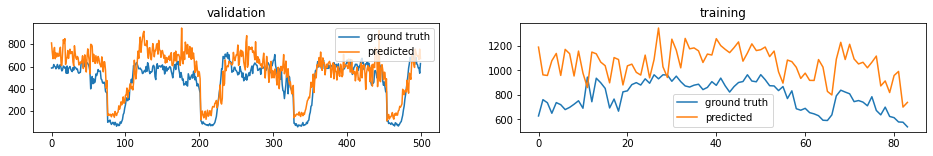

Epoch 15 success, val loss:2029149.75000, train loss:2555479.00000


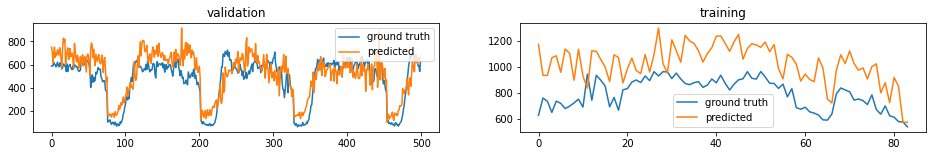

Epoch 20 success, val loss:2026492.75000, train loss:2554809.00000


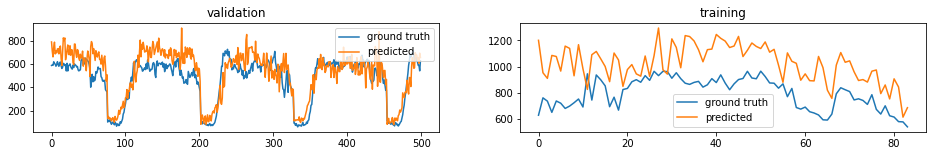

Epoch 25 success, val loss:2024592.87500, train loss:2554073.75000


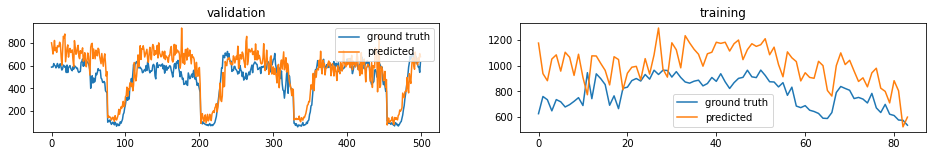

Epoch 30 success, val loss:2027202.50000, train loss:2553544.75000


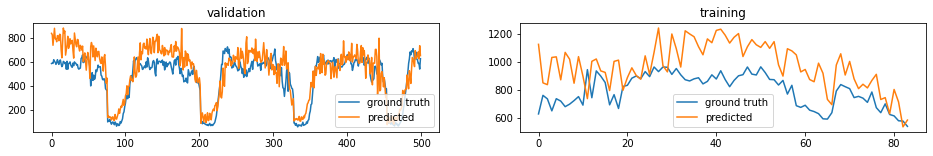

Epoch 35 success, val loss:2031681.37500, train loss:2552607.75000


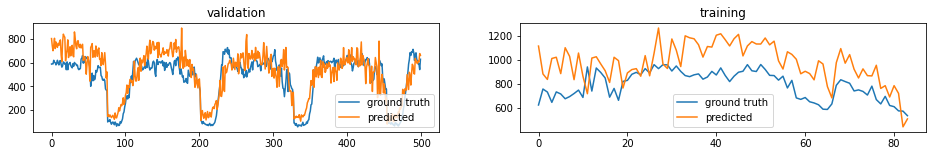

Epoch 40 success, val loss:2028133.75000, train loss:2552486.75000


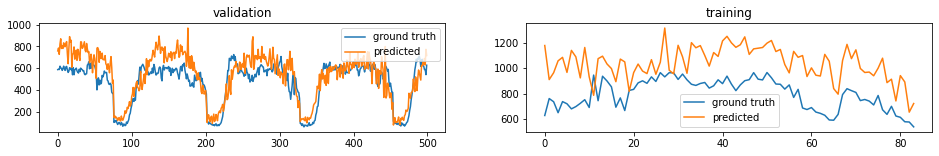

Epoch 45 success, val loss:2028982.87500, train loss:2551527.25000


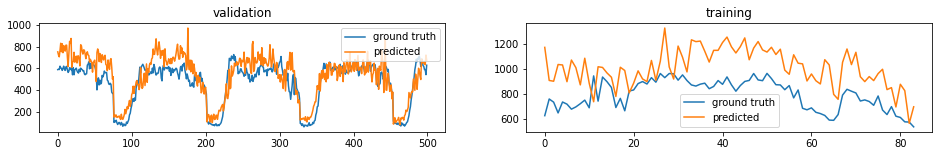

In [311]:
src_train_iter = iter(src_train_loader)
tar_train_iter = iter(tar_train_loader)

epochs = 50
        
for e in range(epochs):
    #ipdb.set_trace()
    for i in range(len(src_train_loader)):
        #print('%i/%i'%(i, len(src_train_loader)))
        try:
            src_data, src_day, src_label = src_train_iter.next()
            tar_data, tar_day, tar_label = tar_train_iter.next()
        except:
            src_train_iter = iter(src_train_loader)
            tar_train_iter = iter(tar_train_loader)
            src_data, src_day, src_label = src_train_iter.next()
            tar_data, tar_day, tar_label = tar_train_iter.next()
        
        src_out, src_out, mmd_loss = traff_dannet(src_data, src_day, src_data)
#         ipdb.set_trace()
        reg_loss = loss_func(src_out, src_label)  # source loss
        
        lambd = 2 / (1 + math.exp(-10 * (e) / epochs)) - 1
        loss = reg_loss + mmd_loss * lambd

        val_out, val_out, val_mmd_loss = traff_dannet(image_test_target, day_test_target, image_test_target)
        val_tar_reg_loss = loss_func(val_out, label_test_target)
        #ipdb.set_trace()
        val_loss = val_tar_reg_loss

        optimizer.zero_grad()
#         ipdb.set_trace()
        loss.backward()
        optimizer.step()

        val_loss_set.append(val_loss.cpu().detach().numpy())
        train_loss_set.append(loss.cpu().detach().numpy())
    
    if e%5==0:
        print('Epoch %i success, val loss:%.5f, train loss:%.5f'%(e, val_loss.cpu().detach().numpy(), loss.cpu().detach().numpy()))
        fig = plt.figure(figsize=[16, 2])
        ax1 = fig.add_subplot(121)
        ax1.plot(label_test_target.cpu().detach().numpy()[:500, 0, 0], label='ground truth')
        ax1.plot(val_out.cpu().detach().numpy()[:500, 0, 0], label='predicted')
        ax1.legend()
        ax1.set_title('validation')
        ax2 = fig.add_subplot(122)
        ax2.plot(src_label.cpu().detach().numpy()[:500, 1, 0], label='ground truth')
        ax2.plot(src_out.cpu().detach().numpy()[:500, 1, 0], label='predicted')
        ax2.legend()
        ax2.set_title('training')
        plt.show()

In [312]:
torch.save(traff_dannet.state_dict(), '../model/net_convnet_pretrained.pth')

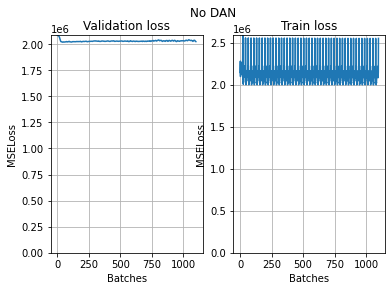

In [313]:
plot_loss(val_loss_set, train_loss_set, 'No DAN')

## Evaluation

In [314]:
def mape_loss_func(preds, labels):
    try:
        if preds.device.type == 'cuda':
            preds = preds.cpu().detach().numpy()
        if labels.device.type == 'cuda':
            labels = labels.cpu().detach().numpy()
    except:
        None
        
    mask = labels > 0.0
    return np.mean(np.fabs(labels[mask]-preds[mask])/labels[mask])

def smape_loss_func(preds, labels):
    try:
        if preds.device.type == 'cuda':
            preds = preds.cpu().detach().numpy()
        if labels.device.type == 'cuda':
            labels = labels.cpu().detach().numpy()
    except:
        None
        
    mask= labels > 0.0
    return np.mean(2*np.fabs(labels[mask]-preds[mask])/(np.fabs(labels[mask])+np.fabs(preds[mask])))

def mae_loss_func(preds, labels):
    try:
        if preds.device.type == 'cuda':
            preds = preds.cpu().detach().numpy()
        if labels.device.type == 'cuda':
            labels = labels.cpu().detach().numpy()
    except:
        None
        
    mask= labels > 0.0
    return np.fabs((labels[mask]-preds[mask])).mean()

def eliminate_nan(b):
    a = np.array(b)
    c = a[~np.isnan(a)]
    return c

In [315]:
traff_dannet.eval()
val_out, val_out, mmd_loss = traff_dannet(image_test_target, day_test_target, image_test_target)

print('MAPE: %.5f'%mape_loss_func(val_out, label_test_target))
print('SMAPE: %.5f'%smape_loss_func(val_out, label_test_target))
print('MAE: %.5f'%mae_loss_func(val_out, label_test_target))


MAPE: 2.45157
SMAPE: 1.02971
MAE: 937.40643


# Finetune using source and target datasets

In [303]:
traff_dannet = traffic_dannet(tar_num_links, t_pre, if_mmd=True).to(device)
traff_dannet.load_state_dict(torch.load('../model/net_convnet_pretrained.pth'))

loss_func = nn.MSELoss()

'''
# 将FT每层的参数从原始网络参数中剔除
ignored_params = list(map(id, traff_dannet.sharedNet.fc1.parameters() ))

base_params = filter(lambda p: id(p) not in ignored_params, traff_dannet.sharedNet.parameters())

# 为fc3层设置需要的学习率
lr_init = 5e-3
optimizer = optim.SGD([
    {'params': base_params},
    {'params': traff_dannet.sharedNet.fc1.parameters(), 'lr': lr_init},
],  lr_init)
'''
val_loss_set_ft = []
train_loss_set_ft = []

num_unfrozen_layer = 2
for i, param in enumerate(traff_dannet.parameters()):
    #print(param.data.shape)
    #print(param.require_grads)
    if i <= num_unfrozen_layer:
        param.requires_grad = True  # false means they are frozen
    else:
        param.requires_grad = False

traff_dannet.train()

NameError: name 'tar_num_links' is not defined

### Select data in source dataset

In [33]:
num_dup = src_train_data.shape[0]//tar_train_data.shape[0]
num_dup = 1

tar_train_data_ft = torch.zeros(
    [tar_train_data.shape[0]*num_dup, tar_train_data.shape[1], tar_train_data.shape[2], tar_train_data.shape[3]]
).to(device)
tar_train_label_ft = torch.zeros(
    [tar_train_label.shape[0]*num_dup, tar_train_label.shape[1], tar_train_label.shape[2]]
).to(device)

for i in range(num_dup):
    tar_train_data_ft[tar_train_data.shape[0]*i:tar_train_data.shape[0]*(i+1), :, :, :] += tar_train_data
    tar_train_label_ft[tar_train_label.shape[0]*i:tar_train_label.shape[0]*(i+1), :, :] += tar_train_label

tar_train_loader_ft = torch.utils.data.DataLoader(
    TensorDataset(tar_train_data_ft, tar_train_label_ft), batch_size, shuffle=False
)  # ft means fine-tune

tar_num_sample = tar_train_data_ft.shape[0]

src_train_loader_ft = torch.utils.data.DataLoader(
    TensorDataset(src_train_data[:tar_num_sample, :], src_train_label[:tar_num_sample, :]), batch_size, shuffle=False
)  # ft means fine-tune


In [34]:
def cal_val_loss(model, loss_func, val_data, val_label, batch_size):
    device = val_data.device.type
    val_dataset = TensorDataset(val_data, val_label)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)
    
    
    output = torch.zeros(val_label.size()).to(device)
    val_loss = 0
    for i, (data, label) in enumerate(val_loader):
        out, out, mmd_loss = model(data, data)
        val_loss = (val_loss + loss_func(out, label))/2
        output[batch_size*i: batch_size*(i+1), :, :] += out
    
    return val_loss, output

In [35]:
optimizer = optim.SGD(traff_dannet.parameters(), lr=0.01)

In [36]:
src_iter = iter(src_train_loader_ft)
tar_iter = iter(tar_train_loader_ft)

epochs = 10

# assert len(src_loader) == len(tar_loader)
   
for e in range(epochs):
    #ipdb.set_trace()
    for i in range(len(src_train_loader_ft)):
        #print('%i/%i'%(i, len(src_train_loader_ft)))
        try:
            src_data, src_label = src_iter.next()
            tar_data, tar_label = tar_iter.next()
        except:
            src_iter = iter(src_train_loader_ft)
            tar_iter = iter(src_train_loader_ft)
            src_data, src_label = src_iter.next()
            tar_data, tar_label = tar_iter.next()
        
        src_out, tar_out, mmd_loss = traff_dannet(src_data, tar_data)
        #ipdb.set_trace()
        reg_loss = loss_func(tar_out, tar_label)  # target loss
        
        lambd = 2 / (1 + math.exp(-10 * (e) / epochs)) - 1
        loss = reg_loss + mmd_loss * lambd

        val_loss, val_out = cal_val_loss(traff_dannet, loss_func, tar_val_data, tar_val_label, batch_size)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        val_loss_set_ft.append(val_loss.cpu().detach().numpy())
        train_loss_set_ft.append(loss.cpu().detach().numpy())
    
    print('Epoch %i success, val loss:%.7f, train loss:%.7f, train_reg_loss:%.7f, train_mmd_loss:%.5f'\
          %(e, val_loss.cpu().detach().numpy(), loss.cpu().detach().numpy(),\
            reg_loss.cpu().detach().numpy(), mmd_loss.cpu().detach().numpy()))
    
    fig = plt.figure(figsize=[16, 2])
    ax1 = fig.add_subplot(121)
    ax1.plot(tar_val_label.cpu().detach().numpy()[:500, 0, 0], label='ground truth')
    ax1.plot(val_out.cpu().detach().numpy()[:500, 0, 0], label='predicted')
    ax1.legend()
    ax1.set_title('target, validation')
    ax2 = fig.add_subplot(122)
    ax2.plot(tar_label.cpu().detach().numpy()[:500, 1, 0], label='ground truth')
    ax2.plot(tar_out.cpu().detach().numpy()[:500, 1, 0], label='predicted')
    ax2.legend()
    ax2.set_title('target, training')
    plt.show()

> c:\users\10169\appdata\local\temp\ipykernel_5824\3579825563.py(39)mmd_rbf_accelerate()

ipdb> source.shape
*** SyntaxError: invalid syntax
ipdb> n
> c:\users\10169\appdata\local\temp\ipykernel_5824\3579825563.py(40)mmd_rbf_accelerate()

ipdb> source.shape
*** SyntaxError: invalid syntax
ipdb> target.shape
torch.Size([256, 30])
ipdb> source
*** SyntaxError: unexpected EOF while parsing
ipdb> source
*** SyntaxError: unexpected EOF while parsing
ipdb> target
tensor([[0.5187, 0.5499, 0.3562,  ..., 0.0000, 0.0000, 0.0000],
        [0.5448, 0.6719, 0.3503,  ..., 0.0000, 0.0000, 0.0000],
        [0.5286, 0.6209, 0.3204,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.3967, 0.6536, 0.3285,  ..., 0.0000, 0.0000, 0.0000],
        [0.3243, 0.6400, 0.2498,  ..., 0.0000, 0.0000, 0.0000],
        [0.3471, 0.5469, 0.2255,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<ReluBackward0>)
ipdb> print(source.shape)
torch.Size([256, 30])
ipdb> q


BdbQuit: 

In [ ]:
mmd_loss

In [ ]:
plot_loss(val_loss_set_ft, train_loss_set_ft, 'Fine Tune')

In [ ]:
torch.save(traff_dannet, '../model/net_convnet_final.pth')

## Evaluation

In [ ]:
traff_dannet.eval()

val_out, val_out, mmd_loss = traff_dannet(tar_val_data, tar_val_data)
#val_out_denormed = denorm_data(val_out, tar_min, tar_max)
#tar_val_label_denormed = denorm_data(tar_val_label, tar_min, tar_max)

print('MAPE: %.5f'%mape_loss_func(val_out, tar_val_label))
print('SMAPE: %.5f'%smape_loss_func(val_out, tar_val_label))
print('MAE: %.5f'%mae_loss_func(val_out, tar_val_label))


# 遇到的问题

- 【已解决：用了相同多的路段数量】source data和target data的num_links数量不一样，模型无法使用：因为网络的卷积核数量是定死的
- 【已解决：使用下述方法】source data和target data的数据天数不一样，模型无法使用：因为数据是分别输入到同一个模型的，因此数据的喂入和batch数量有关，有几个batch就喂几次数据，而天数不同代表num_sample不同，然后batch数量不同。当batch数量不同（比如source data的batch数量更多）时，数据喂到后面就只剩source data了没有target data了

# To do
- 【已用】先用source预训练（无DAN），然后用target data去tune，这样可以解决上面第二个问题